In [ ]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from keras.metrics import MeanRelativeError
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [ ]:
DATA_PATH = 'data_cars/'
all_files = os.listdir(DATA_PATH)

In [ ]:
all_dataframes = []
number_of_files = 100
number_of_sensors = None

for index, file in enumerate(all_files):
    if index == number_of_files:
        break
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    if number_of_sensors:
        all_dataframes.append(df[df.columns[:number_of_sensors]])
    else:
        all_dataframes.append(df)
    print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
combined_df.fillna(method='ffill', inplace=True)
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek

data = np.array(combined_df, dtype=float)
scaler = StandardScaler()
#Don't transform the time labels -> this way the scaler also works inversely on prediction data because shapes are different otherwise
data = np.append(scaler.fit_transform(data[:, :-2]), data[:, -2:], axis=1)

In [ ]:
def split_sequence(seq, look_back, look_forward):
    # Declare X and y as empty list
    X, y = [], []
    # scalers = [StandardScaler() for _ in range(seq.shape[1] - 2)]  # excluding last 2 columns

    # # Apply scalers
    # for i in range(seq.shape[1] - 2):  # excluding last 2 columns
    #     seq[:, i] = scalers[i].fit_transform(seq[:, i].reshape(-1, 1)).flatten()

    for i in range(len(seq)):
        # get the last index
        lastIndex = i + look_back

        # if lastIndex is greater than length of sequence then break
        if lastIndex + look_forward > len(seq):
            break

        # Create input and output sequence
        # Last 2 columns are time of day and day of week
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex+look_forward-1, :-2]

        # append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)

    # Convert X and y into numpy array
    X, y = np.array(X), np.array(y)

    return X, y

In [ ]:
def split_data(data, train_size, val_size, shuffle, look_back, steps_in_future):
    num_of_steps = data.shape[0]

    x, y = split_sequence(data, look_back, steps_in_future)

    if shuffle:
        idx = np.random.permutation(len(x))
        x, y = x[idx], y[idx]

    num_test = int(num_of_steps * (1 - train_size - val_size))
    num_val = int(num_of_steps * val_size)

    x_train, y_train = x[:num_of_steps - num_test - num_val], y[:num_of_steps - num_test - num_val]
    x_val, y_val = x[num_of_steps - num_test - num_val: num_of_steps - num_test], y[num_of_steps - num_test - num_val: num_of_steps - num_test]
    x_test, y_test = x[num_of_steps - num_test:], y[num_of_steps - num_test:]

    return x_train, y_train, x_val, y_val, x_test, y_test


In [ ]:
def smape(predicted, actual):

    numerator = np.abs(predicted - actual)
    denominator = (np.abs(predicted) + np.abs(actual)) / 2

    mask = actual != 0  # Creating a mask to exclude cases where actual value is 0
    
    return np.mean((numerator[mask] / denominator[mask]) * 100)

# def smape(predicted, actual):
#     mask = actual > 20  # Create a mask to identify non-zero values in the actual array
#     numerator = np.abs(predicted - actual)
#     denominator = (np.abs(predicted) + np.abs(actual)) / 2

#     # Filter the arrays based on the mask and NaN values
#     numerator_filtered = numerator[~np.isnan(numerator) & mask]
#     denominator_filtered = denominator[~np.isnan(denominator) & mask]

#     return (numerator_filtered / denominator_filtered) * 100

In [44]:
data.shape[1]

132

In [47]:
def run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=100, batch_size=32):
    # Add params to do optimizing at the top
    print(x_train.shape)
    input_dim = x_train.shape[2]
    units = 128
    output_size = y_train.shape[1]
    look_back = 75

    input = keras.Input((look_back, input_dim))
    #return sequences is necessary for sequential LSTM layers
    lstm1 = LSTM(units, return_sequences=True)(input)
    lstm2 = LSTM(units)(lstm1)
    out = Dense(output_size)(lstm2)
    model = keras.models.Model(inputs=input, outputs=out)
    model.summary()

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.001),
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
        callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    )

    # make predictions
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)        

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(y_train)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(y_test)
    
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
    trainScoreRelative = mean_absolute_percentage_error(trainY, trainPredict)
    
    print(f'Train Score: {trainScore:.2f} RMSE')
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    testScoreRelative = mean_absolute_percentage_error(trainY, trainPredict)
    print(f'Test Score: {testScore:.2f} RMSE')
    
    train_smape = smape(trainPredict, trainY)
    test_smape = smape(testPredict, testY)
    print(f'Train SMAPE: {np.mean(train_smape):.2f}')
    print(f'Test SMAPE: {np.mean(test_smape):.2f}')

    return trainPredict, testPredict, trainScore, testScore, trainY, testY, train_smape, test_smape


In [ ]:

# Check if 'results' directory exists
if not os.path.exists('results'):
    os.makedirs('results')


In [ ]:
results_df = pd.DataFrame()

train_scores = []
test_scores = []
runs = 20
steps_in_future = [1,2,3,4] + [(i*4+1) for i in range(1, 11)]
current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


for i in steps_in_future:
    print(f'Running for {i} steps in future')
    results_df[f'train_score_{i}'] = np.nan
    results_df[f'test_score_{i}'] = np.nan
    results_df[f'train_relative_error_{i}'] = np.nan
    results_df[f'test_relative_error_{i}'] = np.nan

    x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=5/30, shuffle=False, look_back=75, steps_in_future=i)

    for j in range(runs):
        trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)
        results_df.loc[j, f'train_score_{i}'] = train_scores
        results_df.loc[j, f'test_score_{i}'] = test_scores
        results_df.loc[j, f'train_relative_error_{i}'] = np.mean(train_smape)
        results_df.loc[j, f'test_relative_error_{i}'] = np.mean(test_smape)

        
        # results_df.loc[j, f'train_relative_error_{i}'] = train_relative_error
        # results_df.loc[j, f'test_relative_error_{i}'] = test_relative_error
    results_df.to_csv(f'results/results_{current_time}.csv', index=False)
    # train_scores.append(res[2])
    # test_scores.append(res[3])

# results_df[f"train"] = train_scores
# results_df[f"test"] = test_scores
    


In [48]:
single_results_df = pd.DataFrame()


hour_minutes = [data.shape[1]-2, data.shape[1]-1]
hour_minutes
data[:,hour_minutes]
for i in range(data.shape[1]):
    data_used = data[:,[i]+hour_minutes]

    x_train, y_train, x_val, y_val, x_test, y_test = split_data(data_used, train_size=22/30, val_size=5/30, shuffle=False, look_back=75, steps_in_future=1)
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
    trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)
    # Now add the test predictions to the data
    single_results_df[f'prediction_{i}'] = testPredict.flatten()

    # x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=3/30, shuffle=False, look_back=75, steps_in_future=1)

(2112, 75, 3) (2112, 1) (480, 75, 3) (480, 1) (213, 75, 3) (213, 1)
(2112, 75, 3)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 75, 3)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 75, 128)           67584     
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 199,297
Trainable params: 199,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
66/66 [==============================] - 3s 30ms/step - loss: 0.3862 - root_mean_squared_er

ValueError: non-broadcastable output operand with shape (2112,1) doesn't match the broadcast shape (2112,130)

In [19]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=3/30, shuffle=False, look_back=75, steps_in_future=1)


In [20]:
trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 132)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 75, 128)           133632    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 130)               16770     
                                                                 
Total params: 281,986
Trainable params: 281,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
66/66 [==============================] - 3s 31ms/step - loss: 0.3434 - root_mean_squared_error: 0.5860 - val_loss: 0.1495 - val_root_mean_squared_error: 0.3867
Epoch 2/500
6

In [ ]:
smape_train = smape(testPredict, testY)

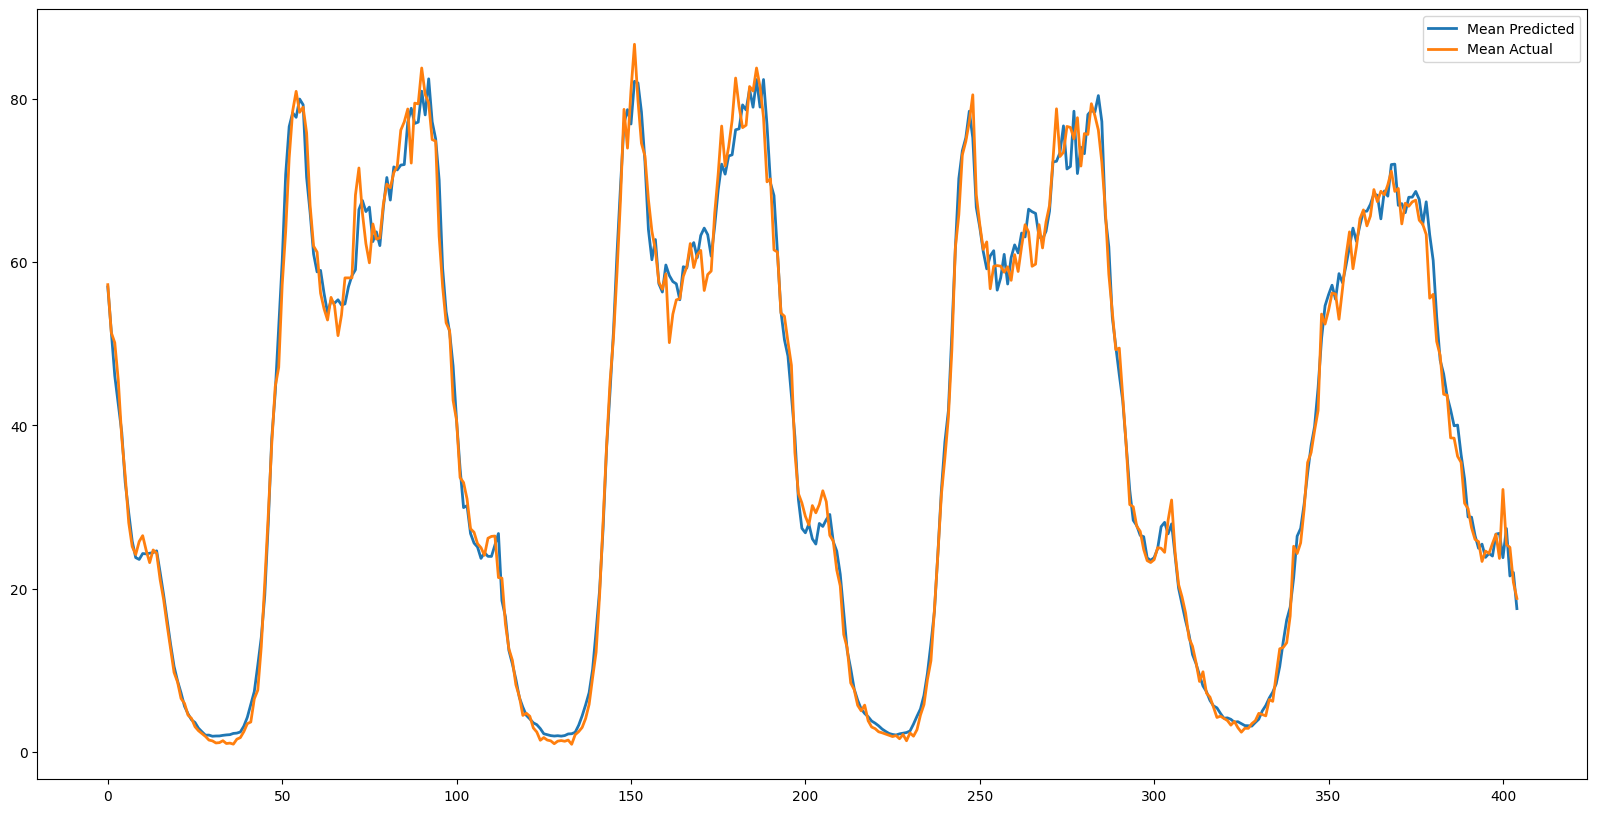

In [21]:

# Assuming testPredict and testY are NumPy arrays of shape (365, 130)
mean_testPredict = np.mean(testPredict, axis=1)
mean_testY = np.mean(testY, axis=1)

# Plot the training predictions
plt.figure(figsize=(20, 10))
# plt.plot(testPredict, label='Predicted')
# plt.plot(testY, label='Actual')
plt.plot(mean_testPredict, label='Mean Predicted', linewidth=2)
plt.plot(mean_testY, label='Mean Actual', linewidth=2)
plt.legend()
plt.show()

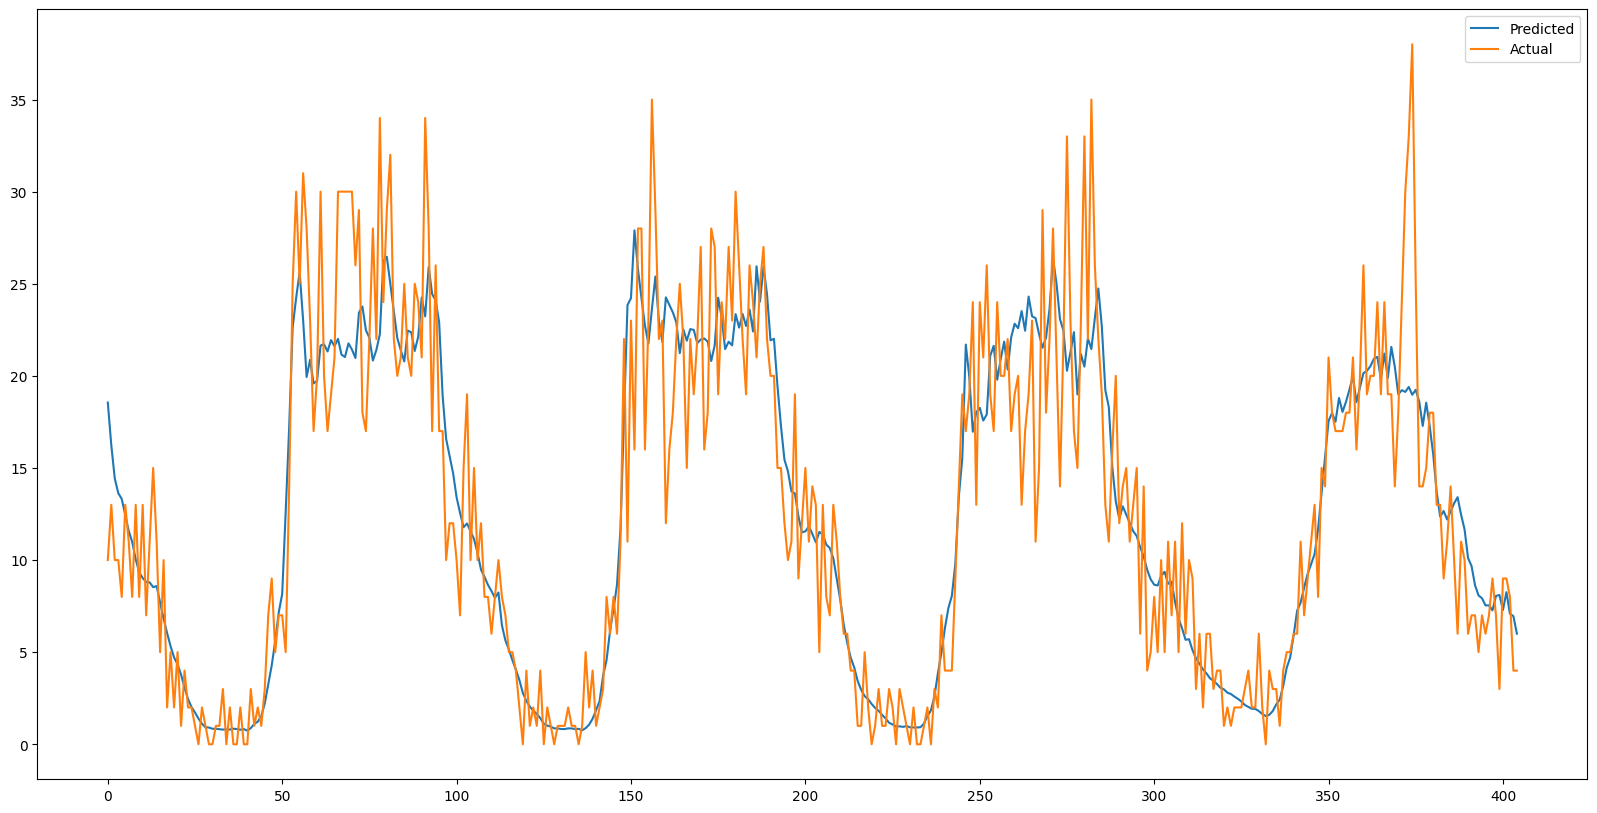

In [22]:
# Plot the training predictions
plt.figure(figsize=(20,10))
plt.plot(testPredict[:, 1], label='Predicted')
plt.plot(testY[:, 1], label='Actual')
plt.legend()
plt.show()

In [ ]:
# Plot the numpy smape_train
plt.figure(figsize=(20,10))

plt.plot(smape_train)
plt.title('SMAPE train')
plt.ylabel('SMAPE')
plt.xlabel('Time')
plt.legend(['SMAPE train'], loc='upper left')
plt.show()

In [ ]:
# Separate train and test mean scores
mean_train_scores = [mean_scores[f'train_score_{t+1}'] for t in range(steps_in_future)]
mean_test_scores = [mean_scores[f'test_score_{t+1}'] for t in range(steps_in_future)]

# Calculate time step * 15 minutes
time_steps = [t * 15 for t in range(1, steps_in_future +1)]

# Create a new figure
plt.figure()

# Plot mean train scores
plt.plot(time_steps, mean_train_scores, label='Train')

# Plot mean test scores
plt.plot(time_steps, mean_test_scores, label='Test')

# Add labels and legend
plt.title("Mean RMSE scores for each step in future")
plt.xlabel('Time (minutes)')
plt.ylabel('RMSE Score')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your code for plotting the training predictions
plt.figure(figsize=(20, 10))
plt.plot(testPredict, label='Predicted')
plt.plot(testY, label='Actual')
plt.legend(loc='upper left')

# Create the second y-axis for the SMAPE train plot
ax2 = plt.gca().twinx()

# Reverse the smape_train array
reversed_smape_train = smape_train

# Your code for plotting the reversed smape_train
ax2.plot(reversed_smape_train, color='green')
ax2.set_ylabel('SMAPE %')
ax2.invert_yaxis()
ax2.legend(['SMAPE'], loc='upper right')

# Set labels and title for the combined plot
plt.xlabel('Time')
plt.title('Predicted vs Actual with SMAPE')

plt.show()

In [ ]:
results_df.mean()

In [ ]:
results

In [ ]:
results_df = pd.DataFrame.from_dict(results)

In [ ]:
results_df.mean()

In [ ]:
train_df = pd.DataFrame(trainPredict, columns=['train_predict'])
train_df['train_actual'] = trainY

In [ ]:
# Make a graph of this
train_df[:100].plot()